In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from random import randrange
import datetime

In [2]:
#now, I need to optimize the parameters
from ax import (
    ComparisonOp,
    ParameterType, 
    RangeParameter,
    SearchSpace, 
    SimpleExperiment, 
    OutcomeConstraint, 
)
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge.factory import Models
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import render, init_notebook_plotting

import torch

In [3]:
#count the number of threads
import multiprocessing
max_worker = multiprocessing.cpu_count()
max_worker -= 5
print(max_worker)

27


In [4]:
N_SAMPLES = 100

In [5]:
def evaluate_parameter(parameter, weight=None):
    
    total_returns = []
    
    q = multiprocessing.Queue(maxsize = max_worker)
    
    
    for iteration in range(0,int(N_SAMPLES/max_worker)+1):
        #print('this is iteration',iteration)
        p_list = []
        for worker in range(0,max_worker):
            
            try:
                if iteration*max_worker+worker<=N_SAMPLES:
                    p = multiprocessing.Process(target = get_window_score,\
                                           args = (q,parameter,iteration*max_worker+worker,\
                                                   False))
                    #print('started one thread and the corresponding window is',iteration*max_worker+worker)
                    p.start()
                    p_list.append(p)
            except:
                pass
        
        for j in range(len(p_list)):
            res = q.get()            
            total_returns.append(res[0])
        
            #print('simulate end value is',res[0])
        
    print('the objective is',np.mean(total_returns)-np.std(total_returns))
    print('the current time is',datetime.datetime.now())
    print(' ')
    
    total_returns_obj = (np.mean(total_returns)-np.std(total_returns), np.std(total_returns) / np.sqrt(N_SAMPLES))
    
    
    
    return {'adj_return': total_returns_obj}

In [6]:
def get_window_score(q, free_parameters, total_data_index, plot_graphs=False):
    
    #current upro holding
    upro_init_quantity = 2800
    
    #obtain a sell schedule based on given free parameters
    linear_day_index = np.array([0,10,20,30,40,50,60,70,80,90])
    linear_hold_pct = np.array([free_parameters['0'],\
                                free_parameters['10'],\
                                free_parameters['20'],\
                                free_parameters['30'],\
                                free_parameters['40'],\
                                free_parameters['50'],\
                                free_parameters['60'],\
                                free_parameters['70'],\
                                free_parameters['80'],\
                                free_parameters['90']])
    day_index_interpolate = []
    hold_pct_interpolate = []
    for day_index in range(0,90):
        index = int(day_index/10)
        if index<len(linear_day_index)-1:
            piecewise_linear_x = linear_day_index[index:index+2]
            piecewise_linear_y = linear_hold_pct[index:index+2]

            linear_parameter = np.polyfit(piecewise_linear_x,piecewise_linear_y,1)
            p = np.poly1d(linear_parameter)

            day_index_interpolate.append(day_index)
            hold_pct_interpolate.append(p(day_index))
            
    
    #trading according to a trading policy
    future_price = total_data[total_data_index,:].tolist()
    actual_cash = 0
    actual_share = upro_init_quantity
    spike_time = known_taper_time[total_data_index]
    tracking_share_count = [actual_share]
    tracking_value = [actual_cash+actual_share*future_price[0]]
    tracking_sold_share = np.zeros((1,90))
    
    for time_index in range(1,90):
        
        if time_index < spike_time:    
            if time_index % 5 == 0:
                need_to_have_share = np.floor(upro_init_quantity*hold_pct_interpolate[time_index])
                sold_share = actual_share-need_to_have_share
                if sold_share>0:
                    actual_cash += sold_share*future_price[time_index]
                    actual_share -= sold_share
                
                
                    tracking_sold_share[0,time_index] = sold_share
        
        if time_index == spike_time+10:
            actual_share += np.floor(actual_cash/future_price[time_index])
            actual_cash = 0
    
        tracking_share_count.append(actual_share)
        tracking_value.append(actual_cash+actual_share*future_price[time_index])
        
    if plot_graphs:
        
        plt.plot(day_index_interpolate,hold_pct_interpolate)
        plt.scatter(linear_day_index,linear_hold_pct,c = 'r')
        plt.show()
        
        plt.plot(tracking_sold_share[0].tolist())
        plt.show()
        
        plt.plot(tracking_share_count)
        plt.show()
        
        plt.plot(future_price)
        plt.show()
        
        plt.plot(tracking_value)
        plt.plot()
        
    #q.put([actual_share*future_price[-1]+actual_cash])
    q.put([actual_share])

In [7]:
search_space = SearchSpace(
    parameters=[
        RangeParameter(name="0", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="10", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="20", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="30", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="40", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="50", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="60", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="70", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="80", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
        RangeParameter(name="90", parameter_type=ParameterType.FLOAT, lower=0, upper=1),
    ]
)

exp = SimpleExperiment(
    name="0",
    search_space=search_space,
    evaluation_function=evaluate_parameter,
    objective_name="adj_return"
)

In [8]:
#load spy data

spy_data = pd.read_csv("SPY.csv")
spy_data = spy_data.rename(columns = {"Date":"Date",\
                           "Open":"spy_open",\
                           "High":'spy_high',\
                           'Low':'spy_low',\
                           'Close':'spy_close',\
                           'Adj Close':'spy_adj_close',\
                           'Volume':'spy_volume'})

In [9]:
spy_data.tail()

,Date,spy_open,spy_high,spy_low,spy_close,spy_adj_close,spy_volume
7113,2021-04-29,420.320007,420.720001,416.440002,420.059998,420.059998,78544300
7114,2021-04-30,417.630005,418.540009,416.339996,417.299988,417.299988,85448400
7115,2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300
7116,2021-05-04,416.070007,416.600006,411.670013,415.619995,415.619995,101591200
7117,2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39873700


In [10]:
#most recent 2000 days

recent_daily_price = spy_data['spy_adj_close'].tolist()[-2000:]

In [11]:
daily_change = [j/i-1 for i, j in zip(recent_daily_price[:-1], recent_daily_price[1:])]

daily_change_mean = np.mean(daily_change)
print(daily_change_mean)
daily_change_std = np.std(daily_change)
print(daily_change_std)

0.0005935722491345876
0.010686090041160256


In [12]:
def risk_density(t):
    #assume an exponential risk increase
    a = 1/10000
    b = np.log(1/a)/90
    return np.exp(-1*a*(np.exp(b*t)-1)/b)*a*np.exp(b*t)

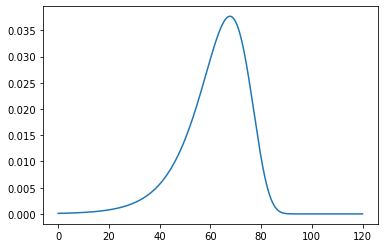

In [13]:
def plot_f_t():
    #this is f(t)
    plot_x = []
    plot_y = []
   
    for x_index in range(0,12000):
        x = x_index/100
        y = risk_density(x)
        plot_x.append(x)
        plot_y.append(y)

    return plot_x,plot_y

plot_x,plot_y = plot_f_t()
plt.plot(plot_x,plot_y)
plt.show()

In [14]:
def compute_cdf():
    cdf_x = []
    pdf_y = []
   
    for x_index in range(0,100000):
    #for x_index in range(-5000,5000):
        x = x_index/1000
        y = risk_density(x)
        cdf_x.append(x)
        pdf_y.append(y)
       
    dx = 1/1000
    cdf_y = [pdf_y[0]*dx]
    for index in range(1,len(pdf_y)):
        cdf_y.append(cdf_y[index-1]+pdf_y[index]*dx)
   
    return cdf_x,cdf_y

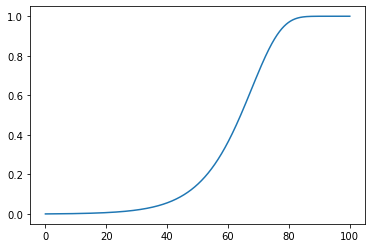

In [15]:
cdf_x,cdf_y = compute_cdf()
plt.plot(cdf_x,cdf_y)
plt.show()

In [16]:
def generate_sample():
    r = uniform.rvs(size = 1)
    index = np.argmin(np.abs(np.array(cdf_y)-r))
    return cdf_x[index]

In [17]:
from scipy.stats import norm
from scipy.stats import uniform


#now, let's repeat the process 1000 times

total_data = np.zeros((0,90))
known_taper_time = []

for simulation_index in range(0,500):
   
    #create one sample
    spike_time = int(generate_sample())

    stock_prices = [100]
    
    for day_index in range(0,90-1):
        
        if day_index == spike_time:
            stock_prices.append(stock_prices[-1]*(1-0.1*3))
            known_taper_time.append(spike_time)
        elif day_index>spike_time and day_index<=spike_time+10:
            simulate_pct_change = norm.rvs(size=1,loc=daily_change_mean*-1,scale=daily_change_std)
            simulate_pct_change = simulate_pct_change[0]*3
            stock_prices.append(stock_prices[-1]*(simulate_pct_change+1))
        else:
            simulate_pct_change = norm.rvs(size=1,loc=daily_change_mean,scale=daily_change_std)
            simulate_pct_change = simulate_pct_change[0]*3
            stock_prices.append(stock_prices[-1]*(simulate_pct_change+1))

           
    #####
    total_data = np.vstack((total_data,stock_prices))

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

print('Running Sobol initialization trials...')
sobol = Models.SOBOL(exp.search_space)
for i in range(100):
    exp.new_trial(generator_run=sobol.gen(1))

cuda
Running Sobol initialization trials...


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)
for i in range(100):
    print(f"Running GP+EI optimization trial {i+1}...")
    # Reinitialize GP+EI model at each step with updated data.
    gpei = Models.GPEI(experiment=exp, data=exp.eval(), dtype=torch.float32, device=device)
    batch = exp.new_trial(generator_run=gpei.gen(1))

cuda
Running GP+EI optimization trial 1...
the objective is 2603.069154609305
the current time is 2021-05-16 16:04:26.325934
 
the objective is 2726.9160995419325
the current time is 2021-05-16 16:04:27.048731
 
the objective is 2659.629726482245
the current time is 2021-05-16 16:04:27.743406
 
the objective is 2765.683807616625
the current time is 2021-05-16 16:04:28.418683
 
the objective is 2597.1895222739363
the current time is 2021-05-16 16:04:29.134418
 
the objective is 2679.633489669236
the current time is 2021-05-16 16:04:29.817007
 
the objective is 2669.655655744845
the current time is 2021-05-16 16:04:30.500362
 
the objective is 2753.4544303926664
the current time is 2021-05-16 16:04:31.180525
 
the objective is 2612.1306882230497
the current time is 2021-05-16 16:04:31.887613
 
the objective is 2722.126014443763
the current time is 2021-05-16 16:04:32.593627
 
the objective is 2615.290453003706
the current time is 2021-05-16 16:04:33.282958
 
the objective is 2767.2589377

the objective is 2741.6889813956004
the current time is 2021-05-16 16:05:33.721939
 
the objective is 2690.3389437390824
the current time is 2021-05-16 16:05:34.430394
 
the objective is 2718.6765430837895
the current time is 2021-05-16 16:05:35.118032
 
Running GP+EI optimization trial 2...
the objective is 2765.980339729867
the current time is 2021-05-16 16:05:41.839010
 
Running GP+EI optimization trial 3...
the objective is 2778.4652985255516
the current time is 2021-05-16 16:05:48.351272
 
Running GP+EI optimization trial 4...
the objective is 2773.129862600137
the current time is 2021-05-16 16:05:54.881534
 
Running GP+EI optimization trial 5...
the objective is 2770.431130106733
the current time is 2021-05-16 16:06:01.957415
 
Running GP+EI optimization trial 6...
the objective is 2770.0999317799565
the current time is 2021-05-16 16:06:09.054863
 
Running GP+EI optimization trial 7...
the objective is 2764.672617492768
the current time is 2021-05-16 16:06:15.722825
 
Running GP+

Running GP+EI optimization trial 67...
the objective is 2825.643624698947
the current time is 2021-05-16 16:17:13.141932
 
Running GP+EI optimization trial 68...
the objective is 2813.545524631537
the current time is 2021-05-16 16:17:28.749596
 
Running GP+EI optimization trial 69...
the objective is 2822.7560740601793
the current time is 2021-05-16 16:17:41.093223
 
Running GP+EI optimization trial 70...
the objective is 2824.2433261058213
the current time is 2021-05-16 16:17:56.321448
 
Running GP+EI optimization trial 71...
the objective is 2824.840947132572
the current time is 2021-05-16 16:18:09.516302
 
Running GP+EI optimization trial 72...
the objective is 2824.031271938322
the current time is 2021-05-16 16:18:23.230069
 
Running GP+EI optimization trial 73...
the objective is 2819.611664371241
the current time is 2021-05-16 16:18:37.025260
 
Running GP+EI optimization trial 74...
the objective is 2822.7864571919963
the current time is 2021-05-16 16:18:52.237954
 
Running GP+EI

In [20]:
_, trial = list(exp.trials.items())[-1]
print(trial)
trial.generator_run
gr = trial.generator_run
best_arm, best_arm_predictions = gr.best_arm_predictions
best_parameters = best_arm.parameters
print(best_parameters)

Trial(experiment_name='0', index=199, status=TrialStatus.CANDIDATE, arm=Arm(name='199_0', parameters={'0': 0.7878826304121606, '10': 1.0, '20': 0.8427033119782554, '30': 0.748911150223046, '40': 0.5537731617578208, '50': 1.757441002546345e-17, '60': 0.3870665692564118, '70': 0.5221864855411456, '80': 0.6762656252681041, '90': 0.4765292682902845}))
{'0': 0.9174604084201455, '10': 0.992196904870353, '20': 0.9474749165807882, '30': 0.5657446247054287, '40': 0.4323311677278866, '50': 0.12110825896993778, '60': 0.5271385846021355, '70': 0.5694200045156097, '80': 0.6525397431952692, '90': 0.41428466644905526}


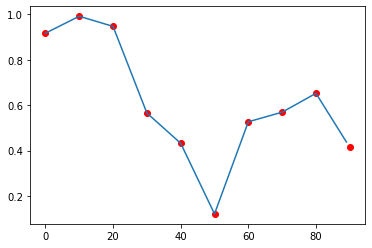

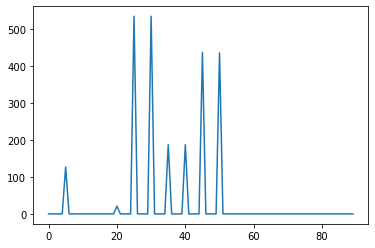

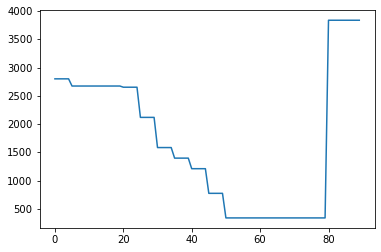

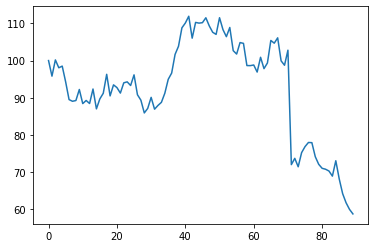

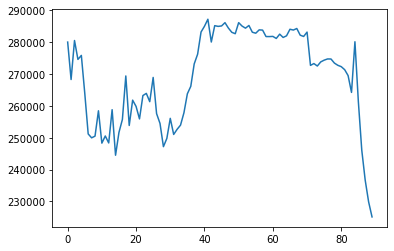

In [23]:
q = multiprocessing.Queue(maxsize = max_worker)
r = get_window_score(q,best_parameters, 10, plot_graphs = True)

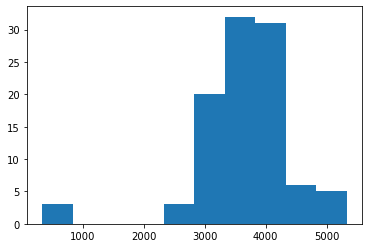

2825.53138035098


In [24]:
q = multiprocessing.Queue(maxsize = max_worker)

res = []

for index in range(0,100):
    r = get_window_score(q,best_parameters, index, plot_graphs = False)
    #r = get_window_score(q,best_parameters, (2000, 6000), CAPITAL, True)
    res.append(q.get()[0])
    
plt.hist(res)
plt.show()

print(np.mean(res)-np.std(res))

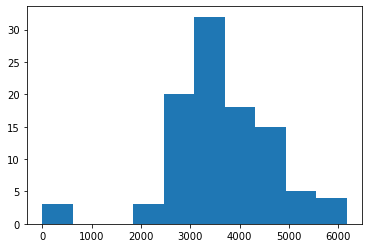

2596.92442572083


In [25]:
trial_parameters ={}
trial_parameters['0'] = 0
trial_parameters['10'] = 0
trial_parameters['20'] = 0
trial_parameters['30'] = 0
trial_parameters['40'] = 0
trial_parameters['50'] = 0
trial_parameters['60'] = 0
trial_parameters['70'] = 0
trial_parameters['80'] = 0
trial_parameters['90'] = 0

q = multiprocessing.Queue(maxsize = max_worker)

res = []

for index in range(0,100):
    r = get_window_score(q,trial_parameters, index, plot_graphs = False)
    #r = get_window_score(q,best_parameters, (2000, 6000), CAPITAL, True)
    res.append(q.get()[0])
    
plt.hist(res)
plt.show()

print(np.mean(res)-np.std(res))

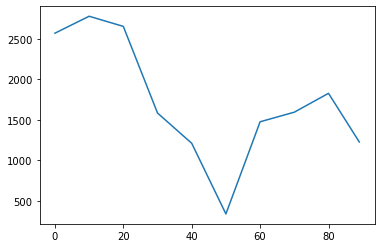

In [28]:
#obtain a sell schedule based on given free parameters
linear_day_index = np.array([0,10,20,30,40,50,60,70,80,90])
linear_hold_pct = np.array([best_parameters['0'],\
                            best_parameters['10'],\
                            best_parameters['20'],\
                            best_parameters['30'],\
                            best_parameters['40'],\
                            best_parameters['50'],\
                            best_parameters['60'],\
                            best_parameters['70'],\
                            best_parameters['80'],\
                            best_parameters['90']])
day_index_interpolate = []
hold_pct_interpolate = []
for day_index in range(0,90):
    index = int(day_index/10)
    if index<len(linear_day_index)-1:
        piecewise_linear_x = linear_day_index[index:index+2]
        piecewise_linear_y = linear_hold_pct[index:index+2]

        linear_parameter = np.polyfit(piecewise_linear_x,piecewise_linear_y,1)
        p = np.poly1d(linear_parameter)

        day_index_interpolate.append(day_index)
        hold_pct_interpolate.append(p(day_index))
        
plt.plot(day_index_interpolate,np.asarray(hold_pct_interpolate)*2800)
plt.show()

In [30]:
print('the current time is',datetime.datetime.now()+datetime.timedelta(days=1))

the current time is 2021-05-17 16:38:37.266878


In [37]:
time = []
share_count = []

for day_index in range(10,50):
    time.append(datetime.datetime.now()+datetime.timedelta(days=day_index))
    share_count.append((np.asarray(hold_pct_interpolate)*2800)[day_index])
    
df = pd.DataFrame()
df['time'] = time
df['share_count'] = share_count
df

,time,share_count
0,2021-05-26 16:54:00.466057,2778.151334
1,2021-05-27 16:54:00.466114,2765.629177
2,2021-05-28 16:54:00.466128,2753.107020
3,2021-05-29 16:54:00.466141,2740.584863
4,2021-05-30 16:54:00.466154,2728.062707
5,2021-05-31 16:54:00.466167,2715.540550
6,2021-06-01 16:54:00.466180,2703.018393
7,2021-06-02 16:54:00.466193,2690.496237
8,2021-06-03 16:54:00.466205,2677.974080
9,2021-06-04 16:54:00.466218,2665.451923
